Agenda
* Load the IMDB dataset
* Load a BERT model from TensorFlow Hub
* Build your own model by combining BERT with a classifier
* Train your own model, fine-tuning BERT as part of that
* Save your model and use it to classify sentences

In [ ]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 29.5 MB/s 
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 438 kB 66.8 MB/s 
     |████████████████████████████████| 1.7 MB 53.4 MB/s 
     |████████████████████████████████| 5.9 MB 49.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [ ]:
#tf-models-official is the stable Model Garden package. Note that it may not include the latest changes in the tensorflow_models github repo. To include latest changes, you may install tf-models-nightly, which is the nightly Model Garden package created daily automatically.
!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 31.8 MB/s 
     |████████████████████████████████| 116 kB 70.1 MB/s 
     |████████████████████████████████| 1.1 MB 58.6 MB/s 
     |████████████████████████████████| 1.3 MB 57.0 MB/s 
     |████████████████████████████████| 238 kB 69.8 MB/s 
     |████████████████████████████████| 38.2 MB 212 kB/s 
     |████████████████████████████████| 352 kB 68.4 MB/s 
     |████████████████████████████████| 636 kB 65.1 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16182 sha256=d1ed6fba0ea37f0c6d7dfb382b1e380ba0fef89a78c5e7d02fb1e53c214299d4
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyY

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

Download the IMDB data

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 9s 0us/step


* Use the text_dataset_from_directory utility to create a labeled tf.data.Dataset.

* The IMDB dataset has already been divided into train and test, but it lacks a validation set. 
* Create a validation set using an 80:20 split of the training data by using the validation_split argument.

* Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation and training splits have no overlap.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
# Check some reviews
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

Load a small BERT model from TensorFlow Hub

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
model_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

preprocess_url =  "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

* The preprocessing model Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. 
* TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. 
* It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

* The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)

In [ ]:
# Illustration of preprocessing layer
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using Bert Model

In [ ]:
bert_model = hub.KerasLayer(model_url)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {model_url}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262903  0.99280983 -0.18611853  0.3667385   0.15233739  0.6550446
  0.9681154  -0.9486271   0.00216157 -0.9877732   0.06842728 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946295  0.34321263  0.33231527 ...  0.2130087   0.71020836
  -0.05771071]
 [-0.2874208   0.31981027 -0.23018518 ...  0.5845508  -0.21329744
   0.7269212 ]
 [-0.66157013  0.6887687  -0.8743292  ...  0.10877226 -0.26173285
   0.47855547]
 ...
 [-0.22561097 -0.2892568  -0.07064426 ...  0.47566074  0.83277184
   0.40025318]
 [-0.29824227 -0.27473107 -0.05450526 ...  0.488498    1.0955358
   0.18163362]
 [-0.4437815   0.00930744  0.07223801 ...  0.17290124  1.1833242
   0.07898009]]


The BERT models return a map with 3 important keys:  
* pooled_output, 
* sequence_output, 
* encoder_outputs:

pooled_output represents each input sequence as a whole. The shape is [batch_size, H] and is an embedding for the entire movie review.

sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H], and is an contextual embedding for every token in the movie review.

encoder_outputs are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.

For the fine-tuning you are going to use the pooled_output array.

In [ ]:
# Define your model
# create a very simple fine-tuned model containint
   # the preprocessing model, 
   # the selected BERT model, 
   # one Dense and a Dropout layer.

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_url, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(model_url, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
#  check that the model runs with the output of the preprocessing model.
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result)) # the output is meaningless as the model is not trained yet

tf.Tensor([[0.63162875]], shape=(1, 1), dtype=float32)


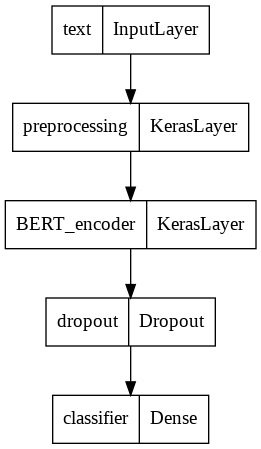

In [ ]:
# review the model
tf.keras.utils.plot_model(classifier_model)

Train the model:
* loss function -- BinaryCrossentropy
* Metrics -- Accuracy
* Optimizer -- "Adaptive Moments" or AdamW, originally used in BERT training.
* The learning rate (init_lr): use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). 

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# Load the BERT model and compile the overall model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
# train the overall model
print(f'Training model with {model_url}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 162s 249ms/step - loss: 0.4870 - binary_accuracy: 0.7441 - val_loss: 0.3763 - val_binary_accuracy: 0.8396
Epoch 2/5
625/625 [==============================] - 153s 245ms/step - loss: 0.3275 - binary_accuracy: 0.8547 - val_loss: 0.3797 - val_binary_accuracy: 0.8440
Epoch 3/5
625/625 [==============================] - 153s 245ms/step - loss: 0.2517 - binary_accuracy: 0.8963 - val_loss: 0.4015 - val_binary_accuracy: 0.8456
Epoch 4/5
625/625 [==============================] - 152s 243ms/step - loss: 0.1531 - binary_accuracy: 0.9420 - val_loss: 0.4764 - val_binary_accuracy: 0.8538


In [ ]:
# Evaluate the model
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 87s 111ms/step - loss: 0.4556 - binary_accuracy: 0.8551
Loss: 0.45562100410461426
Accuracy: 0.8550800085067749


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


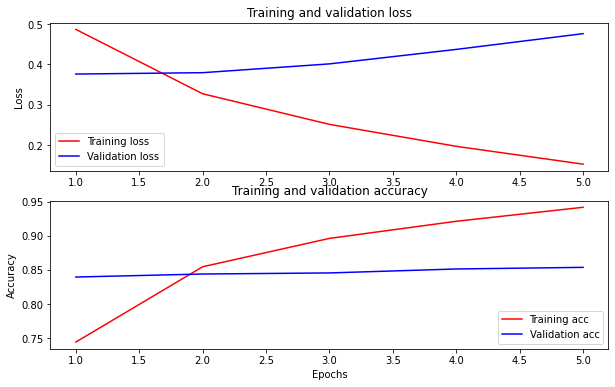

In [ ]:
# Plot accuracy and loss
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# Save or export the model
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
# reload the model for inference
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.998958
input: The movie was great!           : score: 0.993580
input: The movie was meh.             : score: 0.901887
input: The movie was okish.           : score: 0.020047
input: The movie was terrible...      : score: 0.000673

Results from the model in memory:
input: this is such an amazing movie! : score: 0.998958
input: The movie was great!           : score: 0.993580
input: The movie was meh.             : score: 0.901887
input: The movie was okish.           : score: 0.020047
input: The movie was terrible...      : score: 0.000673



In [ ]:
# movie reviews Wakanda 4* MOMD 2.5*
wakanda_review = "An emotional cathartic tribute that provides not only a much-needed release to help us deal with loss but an intelligent political thriller. The performances are extremely personal and moving all around, but Angela Bassett delivers a powerhouse performance. The film is emotionally heavy but knows when to lighten the mood. The humour works. Michaela Coel and Winston duke are underused but hysterical. Danai Gurira also steps up her comedic chops. Having a proper antagonist you can side with is always an element of the best Marvel films or any film for that matter, and they go back with that ingredient to enhance the emotional impact. Tenoch Huerta does a fantastic job getting our buy-in. From a technical aspect, the sound design, and the visual FX are spectacular. The FX has improved by leaps and bounds over the previous film.  Both Oscar winners for the previous film, the score by Ludwig Göransson, and Ruth Carter's costume design, went above their previous work in the franchise and found new ways to incorporate some new elements and not just rely on what they created before. The one minor gripe I have is the introduction of a character who is clearly there because they are getting their own show. At least they are worked in with some purpose as part of the story and the actress Dominique Thorne is pretty good. It's nice to go back to MCU film that feels very personal and easy to engage in. It is like going back to see old friends. Plus the one mid-scene credit actually means something and is not a cryptic throwaway or silly gag as in recent features. Have your Kleenex close at hand. Even at 2h45 it doesn't drag because there is a lot happening in here. There is a storyline or two that we could have left out, but then it would leave the film would not be as rich. Ryan Coogler has given us a beautiful film that gives you closure to a marvel character dear to our hearts. 29 people found this helpful."
momd_review = "Murder, intrigue, suspense: ‘Monica O My Darling’ aims at giving you thrills and spills, and pretty much hits its mark. Robotics expert Jayant Arkhedkar (Rajkummar Rao) is an ambitious man, determined to put his mundane life behind him. When the film opens, it shows him heading straight to the stratosphere, hoicked to a top job in his company, the founder of said company gaga over him, and daughter of said founder enamoured of him. ‘Naukri, ladki, sab kuchh’. You’d think, as would Jayant, that all will henceforth be a bed of roses. But as we know, the best laid plans of mice and men, and in this instance a few reptilian creatures, can and do, go awry. Murders are committed, things go south, and hit rockbottom with an almighty clang. Director Vasan Bala’s penchant for whackiness (‘Mard Ko Dard Nahin Hota’) is evident right from the beginning. A gruesome killing is served as an aperitif, even before we’ve properly settled down. And for the main course, we get misbegotten lust, femme fatales who sway to the one of the most famous cabaret numbers in Hindi cinema (Piya Tu Ab Toh Aaja), and a killer whose biggest achilles heel is his vanity. The proceedings remind you a bit of twisty James Hadley Chase novels. All characters are immoral or plain crooked. And so of course, there’s a flash of ‘Johnny Gaddar’, Sriram Raghavan’s terrific thriller about a heist gone wrong. You can see traces of other well-known films: the director and writer Yogesh Chandekar are clearly Bollywood fanboys, but when they put their paws on an immortal scene from ‘Maqbool’, you want to tell them to back off. Some things can not be improved. And that’s the thing with ‘Monica’. If your USP is being whacked-out, then you have to make sure that nothing slackens. This is even underlined in the film, when one character says to another, ‘dheel nahin dene ka, tight rakhne ka’, or words to that effect. But that ‘dheel’ does occur in bits, especially when a pudgy accountant with a glad eye (Bagavathi Perumal) overstays his welcome on screen, and your attention starts to wander. It’s not like this interesting ensemble cast isn’t working hard to keep a hold on you: Rajkummar Rao is reliably solid, Sikandar Kher livens things up, Sukant Goel as a resentful colleague feeling done in by his co-workers is appropriately shifty. Akansha Ranjan as the rich girl who feels she owns her man leaves a mark, as does Zayn Marie Khan, even if her character is a trifle vague around the edges. Huma Qureshi plays the titular character Monica Macchado, the oomphy secretary who serves the robotics company with a great deal of zeal, and spreads her favours amongst so many senior male employees that you lose track. And then there is ACP Naidu (Radhika Apte) who is assigned to the case, who strides about flinging orders at a male subordinate. Apte has such a blast with the female version of the standard quirky cop that you wish she had more to do. Every time things slowed down, I would stifle impatience, but then they would leap up again, and it would be fine. On the whole, and despite those slow spots, and a few twists which we figure long before the characters do, with a cracker of a beginning and an end which slithers in most unexpectedly, ‘Monica’ ends up being a fun watch."

reviews = [wakanda_review, momd_review]

In [ ]:
reloaded_results = tf.sigmoid(reloaded_model(tf.constant(reviews)))

print('Results from the saved model:')
print_my_examples(reviews, reloaded_results)

Results from the saved model:
input: An emotional cathartic tribute that provides not only a much-needed release to help us deal with loss but an intelligent political thriller. The performances are extremely personal and moving all around, but Angela Bassett delivers a powerhouse performance. The film is emotionally heavy but knows when to lighten the mood. The humour works. Michaela Coel and Winston duke are underused but hysterical. Danai Gurira also steps up her comedic chops. Having a proper antagonist you can side with is always an element of the best Marvel films or any film for that matter, and they go back with that ingredient to enhance the emotional impact. Tenoch Huerta does a fantastic job getting our buy-in. From a technical aspect, the sound design, and the visual FX are spectacular. The FX has improved by leaps and bounds over the previous film.  Both Oscar winners for the previous film, the score by Ludwig Göransson, and Ruth Carter's costume design, went above their p

Reference: https://www.tensorflow.org/text/tutorials/classify_text_with_bert